In [1]:
%pip install opendatasets pandas matplotlib seaborn scikit-learn --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import kaggle
import opendatasets as od
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import zipfile
import json
import glob
import seaborn as sns
from PIL import Image, ImageFile
from tqdm import tqdm, notebook

ImageFile.LOAD_TRUNCATED_IMAGES = True

sns.set(style='darkgrid', font_scale=1.5)

## Download Data

In [2]:
if not os.path.isdir('dataset'):
    dataset = 'https://www.kaggle.com/datasets/qitvision/iwildcam2020-256'
    od.download(dataset, 'dataset')

In [3]:
image_dir = os.path.join('./dataset', 'iwildcam2020-256', '256_images')

In [4]:
train_images_path = os.path.join(image_dir, 'train', 'images')
test_images_path = os.path.join(image_dir, 'test', 'images')

train_jpeg = glob.glob(train_images_path + '/*')
test_jpeg = glob.glob(test_images_path + '/*')

print("Number of Training data:", len(train_jpeg))
print("Number of Testing data:", len(test_jpeg))

Number of Training data: 217953
Number of Testing data: 62894


In [5]:
if not os.path.isdir('annotations'):
    competition_name = 'iwildcam-2020-fgvc7'
    file_name = 'iwildcam2020_train_annotations.json'
    folder_name = './annotations'
    file_path = './annotations/' + '/' + file_name + '.zip'
    kaggle.api.authenticate()
    kaggle.api.competition_download_file(competition=competition_name, file_name=file_name, path=folder_name)
    with zipfile.ZipFile(file_path, 'r') as zip_re:
        zip_re.extractall(path=folder_name)

    os.rename(os.path.join(folder_name, file_name), os.path.join(folder_name, 'train_data.json'))
    os.remove(file_path)

In [6]:
train_annotations_dir = './annotations'
with open(train_annotations_dir + '/train_data.json', 'r') as f:
    train_data = json.load(f)

print(train_data.keys())

dict_keys(['annotations', 'images', 'categories', 'info'])


In [7]:
pd.DataFrame(train_data['annotations']).head()

count                              image_id  \
0      1  96b00332-21bc-11ea-a13a-137349068a90   
1      1  879d74d8-21bc-11ea-a13a-137349068a90   
2      1  9017f7aa-21bc-11ea-a13a-137349068a90   
3      1  90d93c58-21bc-11ea-a13a-137349068a90   
4      1  887cd0ec-21bc-11ea-a13a-137349068a90   

                                     id  category_id  
0  a292dd3c-21bc-11ea-a13a-137349068a90           73  
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4  
2  a306e9c0-21bc-11ea-a13a-137349068a90          227  
3  9eed94c4-21bc-11ea-a13a-137349068a90          250  
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2

In [8]:
pd.DataFrame(train_data['images']).head()

seq_num_frames  location                 datetime  \
0               1       267  2013-08-08 11:45:00.000   
1               1       264  2013-08-01 22:31:00.000   
2               1        45  2013-04-17 11:15:00.000   
3               1        45  2013-04-23 08:26:00.000   
4               1        45  2013-04-24 13:51:00.000   

                                     id  frame_num  \
0  96b00332-21bc-11ea-a13a-137349068a90          1   
1  879d74d8-21bc-11ea-a13a-137349068a90          1   
2  9017f7aa-21bc-11ea-a13a-137349068a90          1   
3  90d93c58-21bc-11ea-a13a-137349068a90          1   
4  887cd0ec-21bc-11ea-a13a-137349068a90          1   

                                 seq_id  width  height  \
0  96b004ea-21bc-11ea-a13a-137349068a90   1795    1222   
1  879d7654-21bc-11ea-a13a-137349068a90   2739    1772   
2  9017f8cc-21bc-11ea-a13a-137349068a90   1891    1222   
3  90d93e38-21bc-11ea-a13a-137349068a90   1795    1222   
4  887cd29a-21bc-11ea-a13a-137349068a90   1812    1196   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [9]:
pd.DataFrame(train_data['categories']).head()

count  id                 name
0  78981   0                empty
1   6355   2       tayassu pecari
2   5833   3  dasyprocta punctata
3    619   4       cuniculus paca
4   4453   6        puma concolor

#### Join the data frames

In [10]:
df_train = pd.DataFrame({'id': [item['id'] for item in train_data['annotations']],
                         'category_id': [item['category_id'] for item in train_data['annotations']],
                         'image_id': [item['image_id'] for item in train_data['annotations']],
                         'file_name': [item['file_name'] for item in train_data['images']]})

df_train.head()

id  category_id  \
0  a292dd3c-21bc-11ea-a13a-137349068a90           73   
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4   
2  a306e9c0-21bc-11ea-a13a-137349068a90          227   
3  9eed94c4-21bc-11ea-a13a-137349068a90          250   
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2   

                               image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [11]:
print(df_train.shape)

(217959, 4)


In [13]:
%%time

indices = []

for i in tqdm(df_train['file_name']):
    try:
        Image.open(train_images_path + '/' + i)
    except:
        print(i)
        df_train.drop(df_train.loc[df_train['file_name'] == i].index, inplace=True)

 57%|█████▋    | 123508/217959 [01:34<00:56, 1676.32it/s]

99136aa6-21bc-11ea-a13a-137349068a90.jpg
87022118-21bc-11ea-a13a-137349068a90.jpg
8f17b296-21bc-11ea-a13a-137349068a90.jpg
883572ba-21bc-11ea-a13a-137349068a90.jpg


 57%|█████▋    | 123828/217959 [01:35<03:04, 510.69it/s] 

896c1198-21bc-11ea-a13a-137349068a90.jpg
8792549a-21bc-11ea-a13a-137349068a90.jpg


100%|██████████| 217959/217959 [02:44<00:00, 1327.69it/s]

CPU times: total: 21.2 s
Wall time: 2min 44s


In [12]:
print(df_train.shape)

(217959, 4)


In [13]:
ID_COL_NAME = 'file_name'
LABEL_COL_NAME = 'category_id'

In [14]:
train_df, validation_df = train_test_split(df_train[[ID_COL_NAME, LABEL_COL_NAME]], test_size=0.25, shuffle=True)

train_df.head()

file_name  category_id
180615  925f6c82-21bc-11ea-a13a-137349068a90.jpg            3
171697  95769012-21bc-11ea-a13a-137349068a90.jpg          375
97579   877afb2e-21bc-11ea-a13a-137349068a90.jpg            0
211474  92bc2616-21bc-11ea-a13a-137349068a90.jpg            6
119212  8bdbb802-21bc-11ea-a13a-137349068a90.jpg            0

## Training Data Images

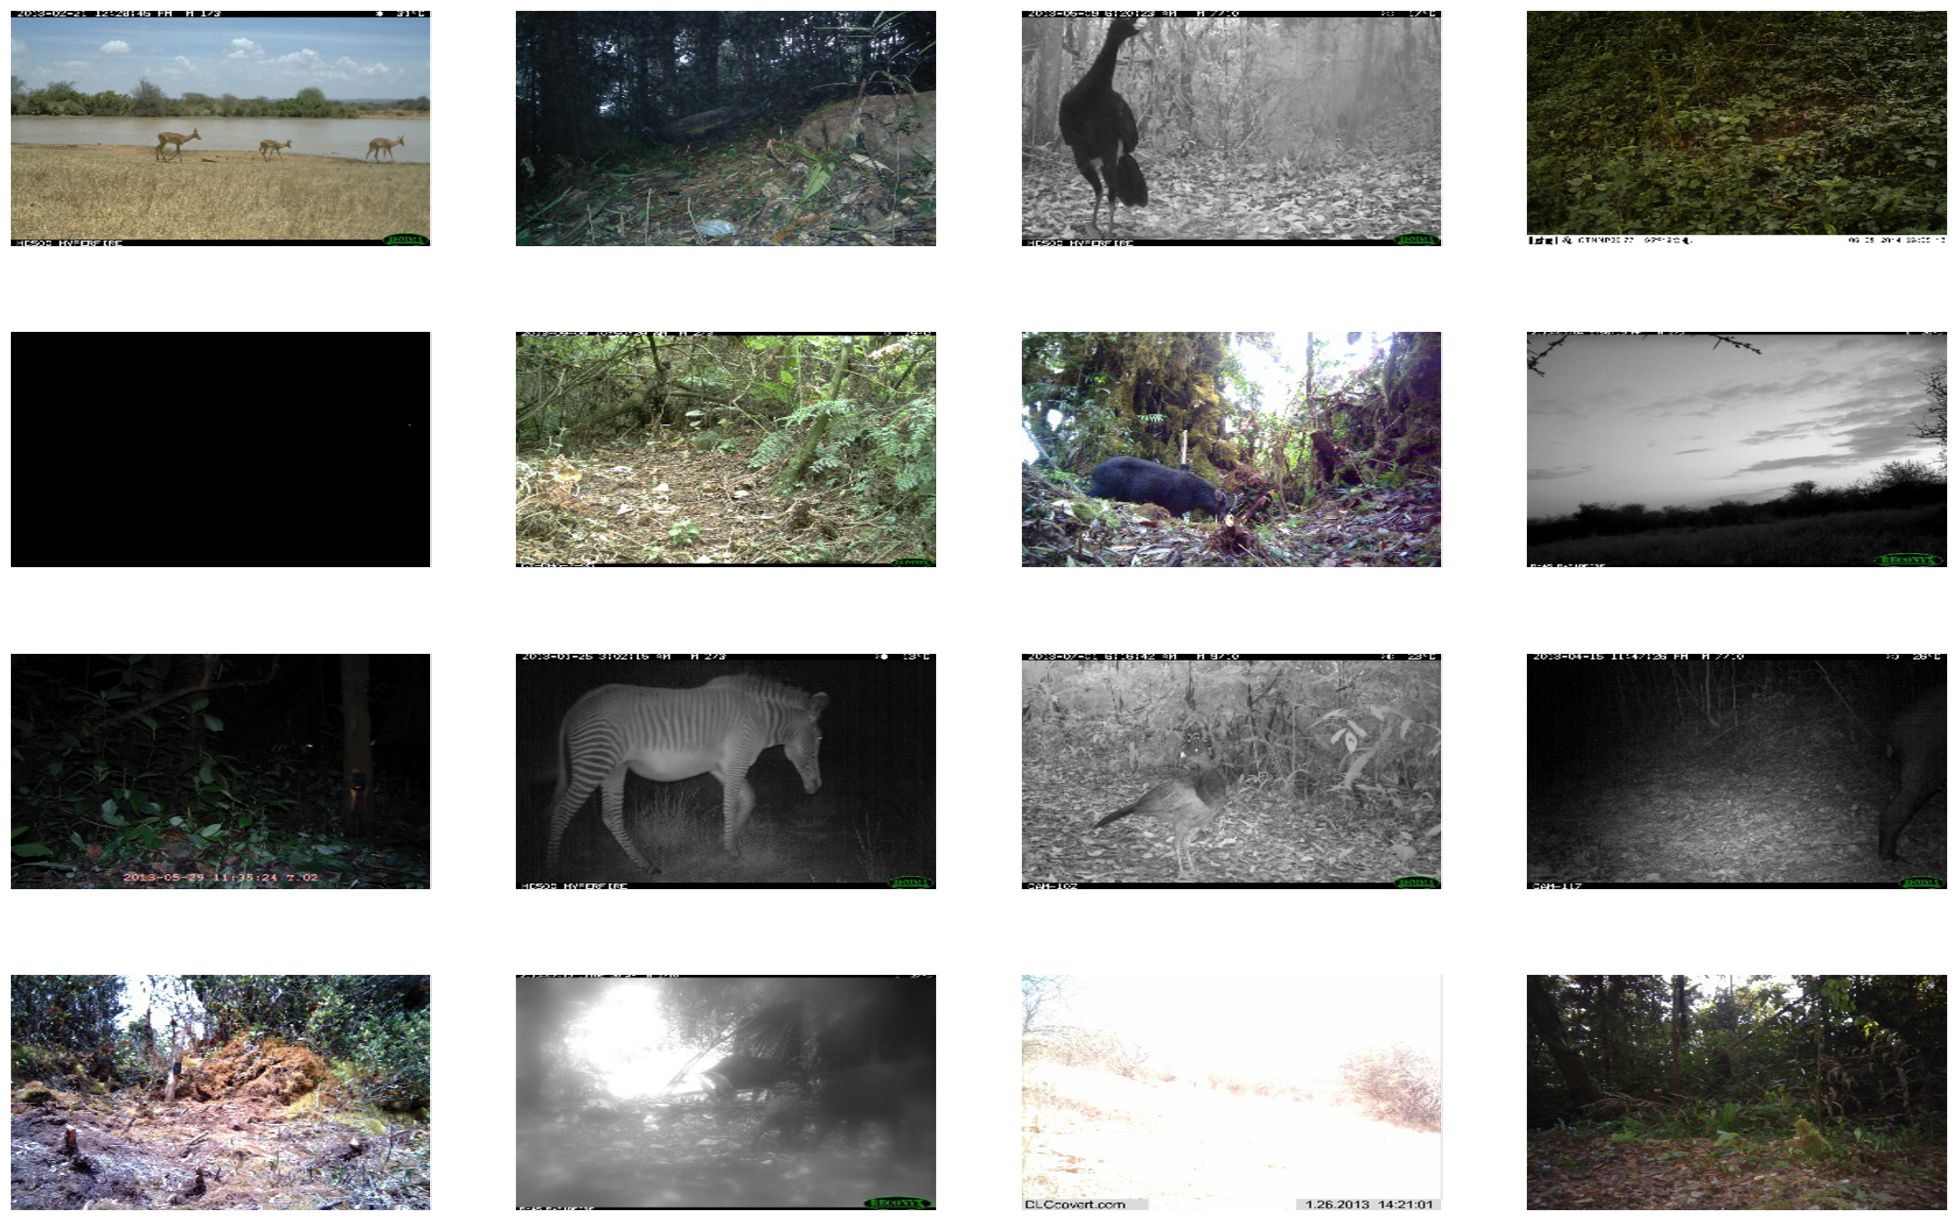

In [15]:
fig = plt.figure(figsize=(25, 16))
for i, im_path in enumerate(train_jpeg[:16]):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480, 270))
    plt.imshow(im)

## Test Data Images

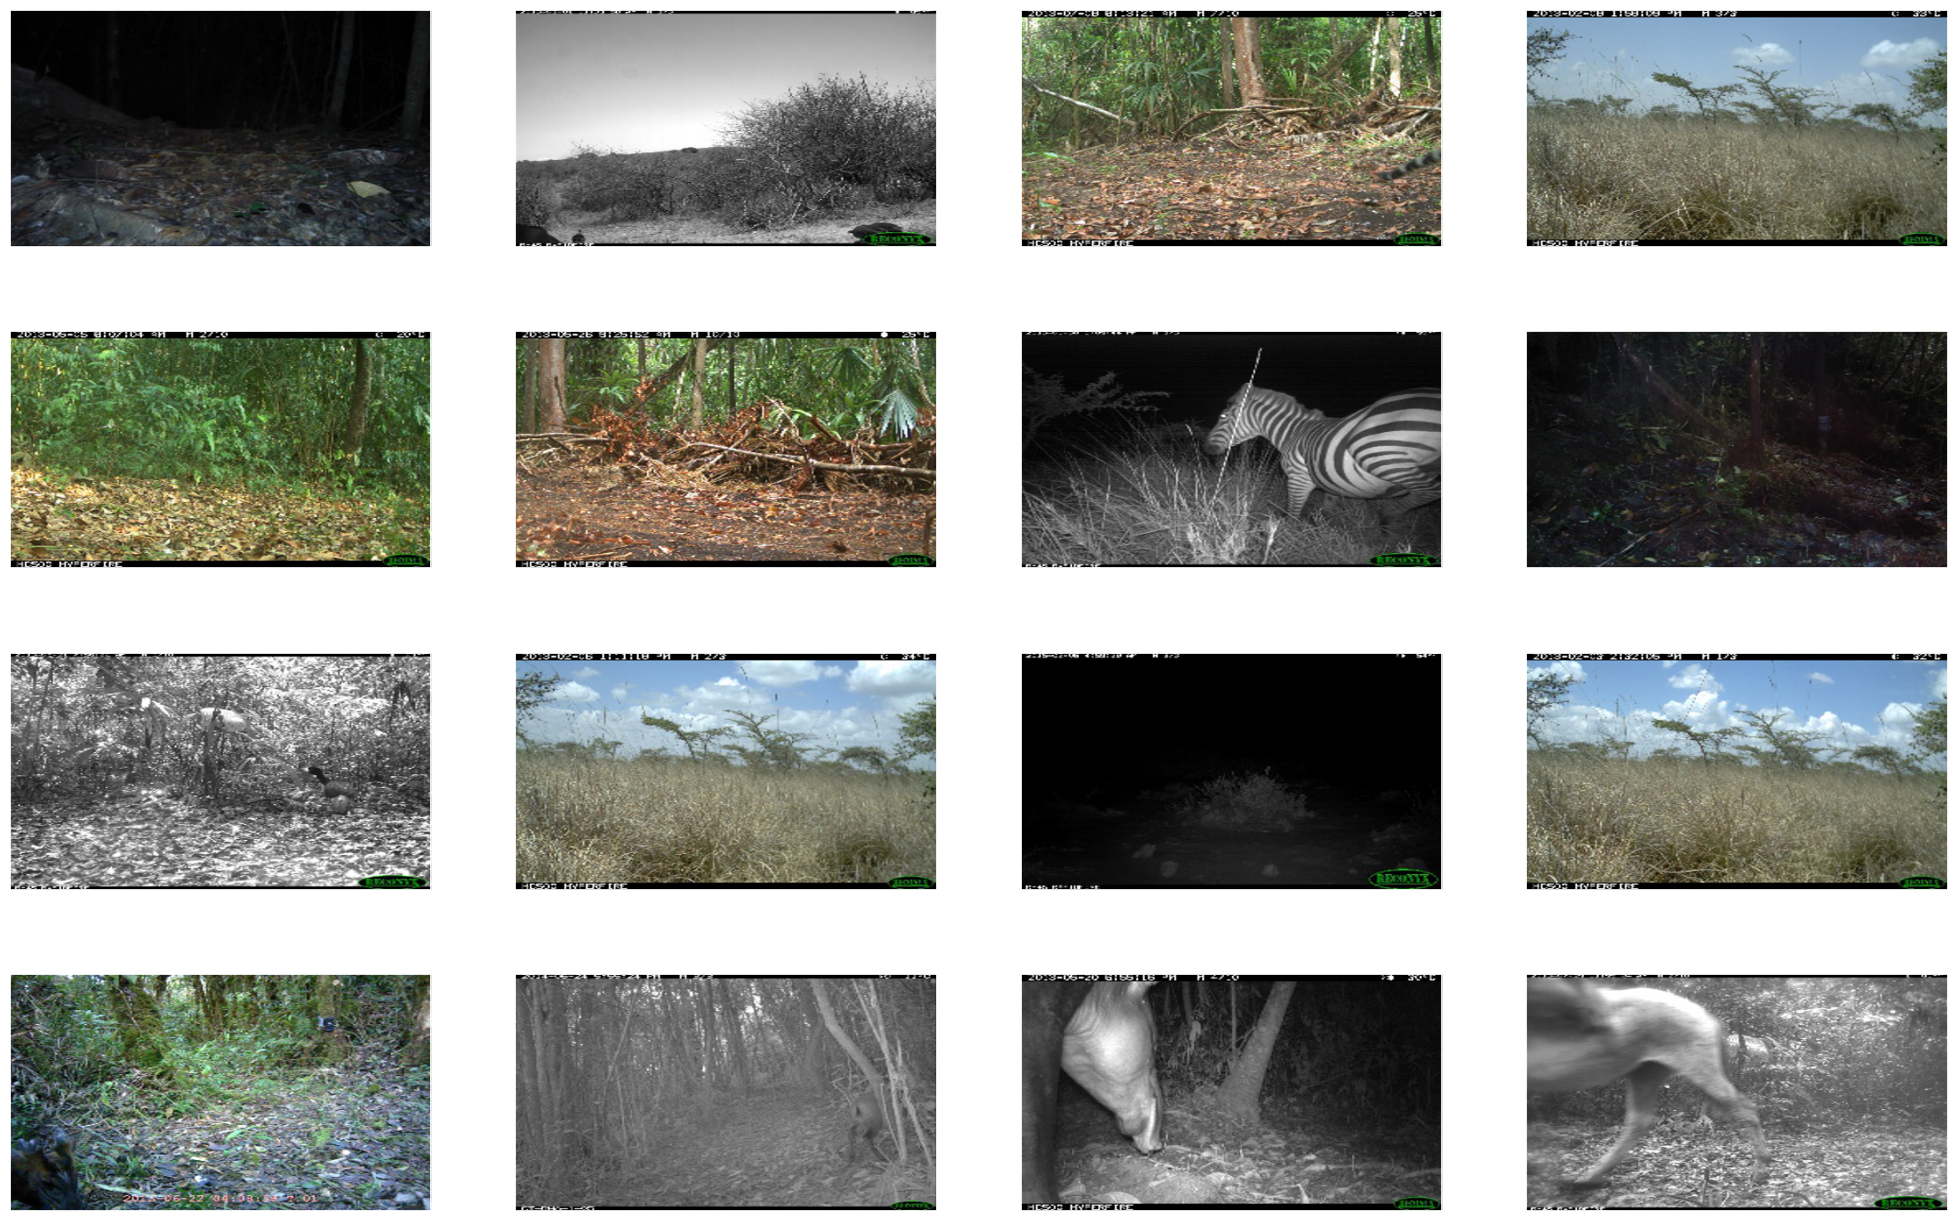

In [16]:
fig = plt.figure(figsize=(25, 16))
for i, im_path in enumerate(test_jpeg[:16]):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480, 270))
    plt.imshow(im)

## Data Visualization

In [17]:
CLASSES_TO_USE = df_train['category_id'].unique()
CLASSES_TO_USE

array([ 73,   4, 227, 250,   2, 233, 230,   6,  15,  10,  50,   9, 198,
        16, 234, 229,   7,  14,   8, 251, 235, 252, 253, 315, 316, 317,
       318, 319, 161,  91, 320, 321, 322, 323, 324, 325, 326, 327, 333,
       334, 335, 336, 337, 338, 339, 340, 332, 341, 116, 328, 344, 345,
       346,  90,  77,   0, 347, 111, 112, 348, 265, 127, 101, 113,  71,
       118, 108, 120,  78, 110, 115,  96, 104, 349,  74,  97,  94, 258,
       103, 102, 350, 177, 259, 162, 256,  72,  79,  83, 267, 268, 119,
       122,  70, 167, 163, 133, 166, 114,  98, 124, 123, 121, 100, 257,
       286, 262, 129,  89, 352, 353, 354, 355, 330, 356, 357, 342,  24,
       372, 376, 378, 377, 290, 134,  80, 273,  92, 130,  86, 106, 170,
       144, 147, 291, 153, 405, 152, 154, 406, 407, 309, 408, 409, 410,
       137, 300, 299, 145, 412, 389, 175, 390, 413, 307, 142, 391, 306,
       310, 292, 414, 156, 415, 139, 301, 416, 404, 302, 417, 418, 419,
       420, 159, 294, 141, 150, 402, 296,  32,  62,  13, 370, 42

In [18]:
NUM_CLASSES = len(CLASSES_TO_USE)
NUM_CLASSES

216

In [19]:
CLASSMAP = dict(list(zip(CLASSES_TO_USE, range(NUM_CLASSES))))
REVERSE_CLASSMAP = dict([(v, k) for k, v in CLASSMAP.items()])

## Setup Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [21]:
model=models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

In [22]:
new_head = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
model.classifier = new_head

In [23]:
try:
    model.cuda()
except:
    pass

### Training Configurations

In [24]:
N_EPOCHS = 4

### Transformations

In [33]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [34]:
class IMetDataset(Dataset):
    
    def __init__(self,
                 df,
                 images_dir,
                 n_classes = NUM_CLASSES,
                 id_colname = ID_COL_NAME,
                 answer_colname = LABEL_COL_NAME,
                 label_dict = CLASSMAP,
                 transforms = None
                ):
        self.df = df
        self.images_dir = images_dir
        self.n_classes = n_classes
        self.id_colname = id_colname
        self.answer_colname = answer_colname
        self.label_dict = label_dict
        self.transforms = transforms
        self.df['image_path'] = self.df[ID_COL_NAME].apply(lambda x: os.path.join(self.images_dir, x))
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):        
        cur_idx_row = self.df.iloc[idx]
        img_id = cur_idx_row[self.id_colname]
        img_name = img_id # + self.img_ext
        img_path = self.df.iloc[idx]['image_path']

        img = Image.open(img_path)

        if self.transforms is not None:
            img = self.transforms(img)

        if self.answer_colname is None:
            return img, img_id
        label = torch.zeros((self.n_classes,), dtype=torch.float32)
        label[self.label_dict[cur_idx_row[self.answer_colname]]] = 1.0

        return img, label  


In [35]:
train_dataset = IMetDataset(train_df, train_images_path, transforms = train_transforms)
val_dataset = IMetDataset(validation_df, train_images_path, transforms = val_transforms)

In [36]:
BS = 48

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)

TypeError: Invalid shape (3, 256, 256) for image data

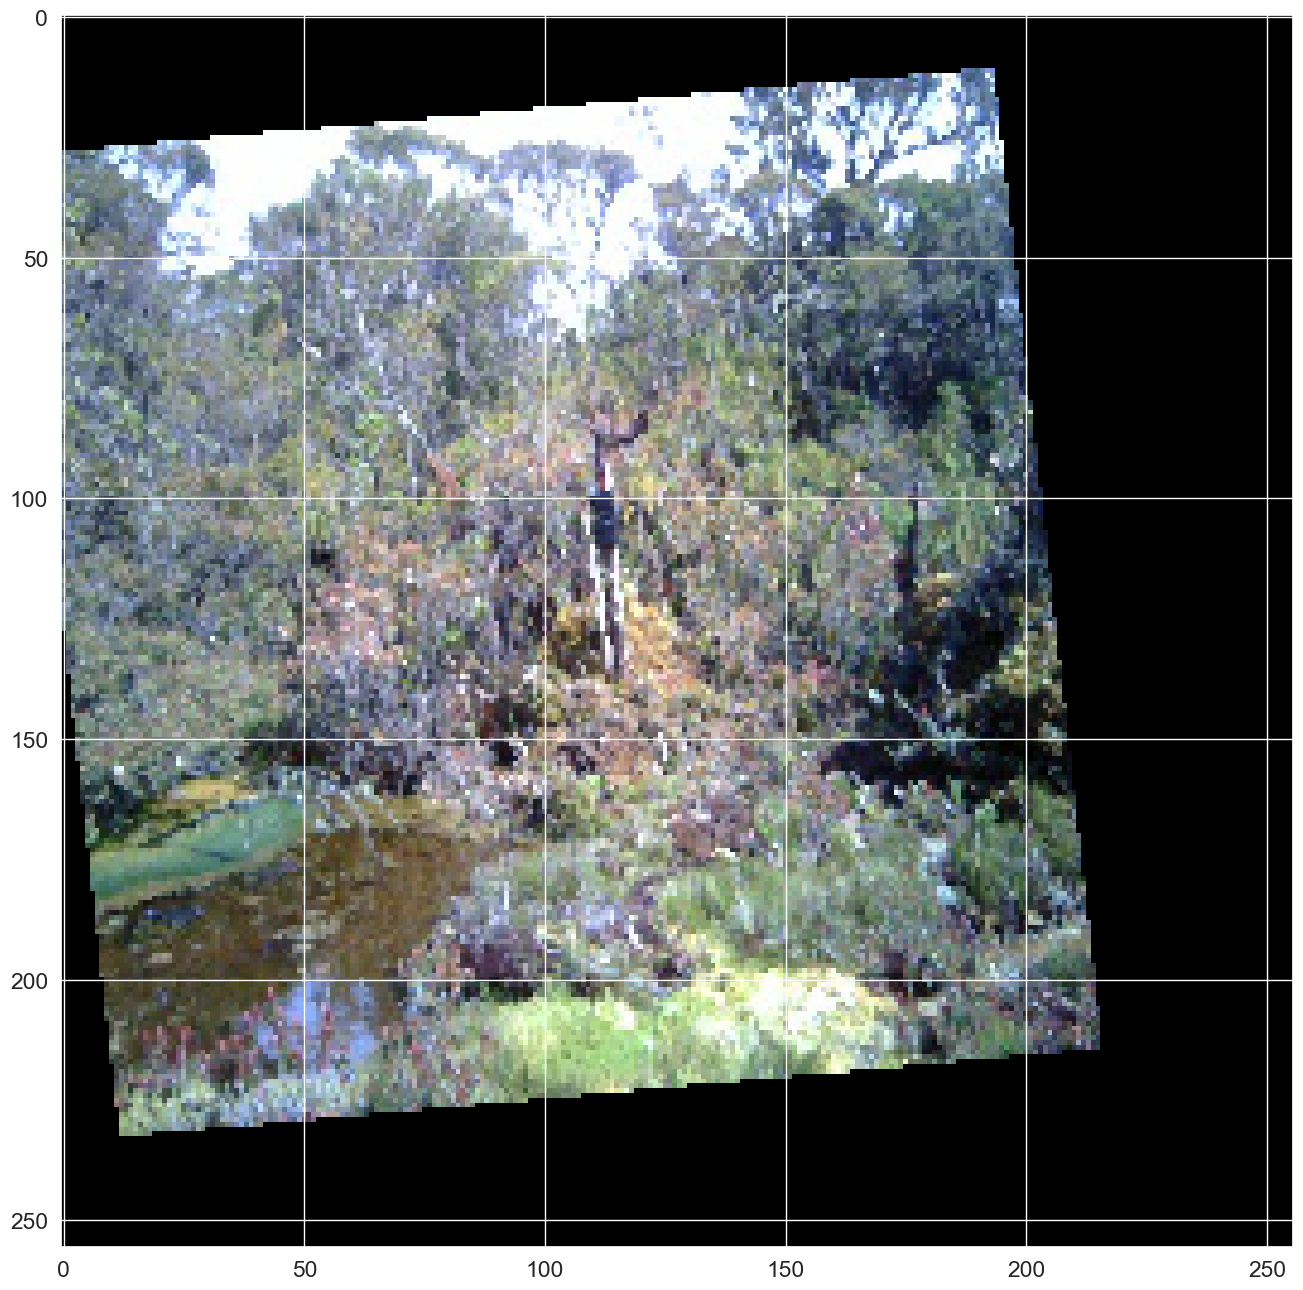

In [38]:
import numpy as np

img, label = train_dataset.__getitem__(2)

plt.figure(figsize=(25, 16))
inp = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)
plt.imshow(img)
plt.show()


In [40]:
def cuda(x):
    return x.cuda(non_blocking=True)

In [41]:
def f1_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 1, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [42]:
import contextlib
def train_one_epoch(model, train_loader, criterion, optimizer, steps_upd_logging = 250):
    model.train()

    total_loss = 0.0

    train_tqdm = notebook.tqdm(train_loader)


    for step, (features, targets) in enumerate(train_tqdm):
        with contextlib.suppress(Exception):
            features, targets = cuda(features), cuda(targets)

            optimizer.zero_grad()

            logits = model(features)

            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (step + 1) % steps_upd_logging == 0:
                logstr = f'Train loss on step {step + 1} was {round(total_loss / (step + 1), 5)}'
                train_tqdm.set_description(logstr)
                print(logstr)
    return total_loss / (step + 1)


In [43]:
def validate(model, valid_loader, criterion, need_tqdm = False):
    model.eval()

    test_loss = 0.0
    TH_TO_ACC = 0.5

    true_ans_list = []
    preds_cat = []

    with torch.no_grad():
        
        valid_iterator = notebook.tqdm(valid_loader) if need_tqdm else valid_loader
        for step, (features, targets) in enumerate(valid_iterator):
            features, targets = cuda(features), cuda(targets)

            logits = model(features)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            true_ans_list.append(targets)
            preds_cat.append(torch.sigmoid(logits))

        all_true_ans = torch.cat(true_ans_list)
        all_preds = torch.cat(preds_cat)

        f1_eval = f1_score(all_true_ans, all_preds).item()

    logstr = f'Mean val f1: {round(f1_eval, 5)}'
    print(logstr)
    return test_loss / (step + 1), f1_eval


In [44]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [ ]:
# %%time
# 
# TRAIN_LOGGING_EACH = 500
# 
# train_losses = []
# valid_losses = []
# valid_f1s = []
# best_model_f1 = 0.0
# best_model = None
# best_model_ep = 0
# 
# for epoch in range(1, N_EPOCHS + 1):
#     ep_logstr = f"Starting {epoch} epoch..."
#     print(ep_logstr)
#     tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, TRAIN_LOGGING_EACH)
#     train_losses.append(tr_loss)
#     tr_loss_logstr = f'Mean train loss: {round(tr_loss,5)}'
#     print(tr_loss_logstr)
# 
#     valid_loss, valid_f1 = validate(model, val_loader, criterion)  
#     valid_losses.append(valid_loss)    
#     valid_f1s.append(valid_f1)       
#     val_loss_logstr = f'Mean valid loss: {round(valid_loss,5)}'
#     print(val_loss_logstr)
#     sheduler.step(valid_loss)
# 
#     if valid_f1 >= best_model_f1:    
#         best_model = model        
#         best_model_f1 = valid_f1        
#         best_model_ep = epoch

Starting 1 epoch...


  0%|          | 0/3406 [00:00<?, ?it/s]